# Project: Sign Language Recognition

## Importing libraries

In [17]:
pip install split-folders tensorflow kagglehub

Note: you may need to restart the kernel to use updated packages.


In [9]:
import numpy as np
import os
import re
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, LSTM, Reshape, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import pandas as pd
import time
import matplotlib.pyplot as plt
import splitfolders

### Loading the ASL dataset and splitting into train and test

In [11]:
import os
import shutil

# Define the path to kaggle.json in the current directory
kaggle_json_path = "kaggle.json"

# Check if kaggle.json exists
if os.path.exists(kaggle_json_path):
    # Create the ~/.kaggle directory if it doesn't exist
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    
    # Copy kaggle.json to ~/.kaggle/
    shutil.copy(kaggle_json_path, os.path.expanduser("~/.kaggle/kaggle.json"))
    
    # Set correct permissions
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    
    # Execute Kaggle CLI command to list datasets
    os.system("kaggle datasets list")
else:
    print(f"File {kaggle_json_path} not found in the current directory!")


In [13]:
ls

 Volume in drive C is Windows-SSD
 Volume Serial Number is A8BD-917B

 Directory of C:\Users\grigal\Documents\neunet\NeuNets

01/03/2025  06:36 PM    <DIR>          .
01/03/2025  06:35 PM    <DIR>          ..
01/03/2025  06:35 PM                 8 .dockerignore
01/03/2025  06:35 PM                10 .gitignore
01/03/2025  06:36 PM    <DIR>          .ipynb_checkpoints
01/03/2025  06:35 PM               469 docker-compose.yaml
01/03/2025  06:35 PM               693 Dockerfile
01/03/2025  06:35 PM               481 DockerfileCPU
01/03/2025  06:35 PM                64 kaggle.json
01/03/2025  06:35 PM             5,957 main.py
01/03/2025  06:35 PM           261,652 Project.ipynb
01/03/2025  06:35 PM                67 README.md
               9 File(s)        269,401 bytes
               3 Dir(s)  434,973,249,536 bytes free


In [19]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("debashishsau/aslamerican-sign-language-aplhabet-dataset")

print("Path to dataset files:", path)

100%|██████████| 4.20G/4.20G [02:36<00:00, 28.8MB/s]

Extracting files...


Path to dataset files: C:\Users\grigal\.cache\kagglehub\datasets\debashishsau\aslamerican-sign-language-aplhabet-dataset\versions\1


In [21]:
os.chdir(path)

In [23]:
!ls path / 'ASL_Alphabet_Dataset/asl_alphabet_train'

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [31]:
from pathlib import Path
# path where our data is located
base_path = Path(path) / "/ASL_Alphabet_Dataset/asl_alphabet_train/"

# dictionary to save our 29 classes
categories = {  0: "A",
                1: "B",
                2: "C",
                3: "D",
                4: "E",
                5: "F",
                6: "G",
                7: "H",
                8: "I",
                9: "G",
                10: "K",
                11: "L",
                12: "M",
                13: "N",
                14: "O",
                15: "P",
                16: "Q",
                17: "R",
                18: "S",
                19: "T",
                20: "U",
                21: "V",
                22: "W",
                23: "X",
                24: "Y",
                25: "Z",
                26: "del",
                27: "nothing",
                28: "space",
            }

def add_class_name_prefix(df, col_name):
    df[col_name]
    return df


# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = pathlib.iterdir(base_path / categories[category])
    filenames_list = filenames_list / filenames
    categories_list = categories_list / [category] * len(filenames)

df = pd.DataFrame({"filename": filenames_list, "category": categories_list})
df = add_class_name_prefix(df, "filename")

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\ASL_Alphabet_Dataset\\asl_alphabet_train\\A'

In [32]:
output_path = './asl_dataset_split'
splitfolders.ratio(base_path, output=output_path, seed=1333, ratio=(0.8, 0.1, 0.1))



Copying files: 0 files [00:00, ? files/s]

Copying files: 109 files [00:00, 1088.91 files/s]

Copying files: 433 files [00:00, 2352.15 files/s]

Copying files: 744 files [00:00, 2695.13 files/s]

Copying files: 1062 files [00:00, 2885.64 files/s]

Copying files: 1387 files [00:00, 3014.64 files/s]

Copying files: 1700 files [00:00, 3051.97 files/s]

Copying files: 2018 files [00:00, 3092.23 files/s]

Copying files: 2328 files [00:00, 3087.80 files/s]

Copying files: 2637 files [00:00, 3050.90 files/s]

Copying files: 2957 files [00:01, 3095.83 files/s]

Copying files: 3296 files [00:01, 3183.14 files/s]

Copying files: 3660 files [00:01, 3319.73 files/s]

Copying files: 4018 files [00:01, 3395.25 files/s]

Copying files: 4372 files [00:01, 3437.24 files/s]

Copying files: 4717 files [00:01, 3439.66 files/s]

Copying files: 5062 files [00:01, 3402.56 files/s]

Copying files: 5403 files [00:01, 3210.92 files/s]

Copying files: 5727 files [00:01, 3217.83 files/s]

Copying files: 6071 fi

In [36]:
# Define explicit paths for train, val, and test
train_path = os.path.join(output_path, 'train')
val_path = os.path.join(output_path, 'val')
test_path = os.path.join(output_path, 'test')

print(f"Train data saved at: {train_path}")
print(f"Validation data saved at: {val_path}")
print(f"Test data saved at: {test_path}")

Train data saved at: ./asl_dataset_split/train
Validation data saved at: ./asl_dataset_split/val
Test data saved at: ./asl_dataset_split/test


In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Parameters
image_size = 64  # resizing images to 64x64
batch_size = 32  

# data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # normalize pixel values to [0, 1]
    validation_split=0.2  # split data into training and validation
)

# training data
train_data = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# validation data
val_data = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# test data
test_data = datagen.flow_from_directory(
    directory=test_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Verifying shapes
print(f"Number of training samples: {train_data.samples}")
print(f"Number of validation samples: {val_data.samples}")
print(f"Number of test samples: {test_data.samples}")


Found 142769 images belonging to 29 classes.
Found 35678 images belonging to 29 classes.
Found 22332 images belonging to 29 classes.
Number of training samples: 142769
Number of validation samples: 35678
Number of test samples: 22332


In [30]:
print(os.listdir('/kaggle/working/'))

['train', 'val', 'test']


## Load pretrained ResNet-50, building rnn, cnn and hybrid model

In [38]:
# loading pretrained ResNet-50

def load_resnet_base(input_shape=(64, 64, 3)):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    return base_model

resnet_base_model = load_resnet_base()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step


In [39]:
def resnet_with_rnn(base_model, rnn_layers=2):
    base_model.trainable = False # we are freezing the base_model
    inputs = Input(shape=(64, 64, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Reshape((1, -1))(x)
    for _ in range(rnn_layers):
        x = LSTM(64, return_sequences=True)(x)
    x = LSTM(64)(x)
    outputs = Dense(29, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model 

resnet_rnn_model = resnet_with_rnn(resnet_base_model)

## Building the CNN model

In [40]:
def resnet_with_cnn(base_model, cnn_layers=2):
    base_model.trainable = False # we are freezing the base_model
    inputs = Input(shape=(64, 64, 3))
    x = base_model(inputs, training=False)
    for _ in range(cnn_layers - 1):
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(29, activation='softmax')(x)  # Updated for 29 classes
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

resnet_cnn_model = resnet_with_cnn(resnet_base_model)


## Training the models

In [41]:
def hybrid_resnet_cnn_rnn(base_model):
    base_model.trainable = False
    inputs = Input(shape=(64, 64, 3))
    x = base_model(inputs, training=False)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = GlobalAveragePooling2D()(x)
    x = Reshape((1, -1))(x)
    x = LSTM(64, return_sequences=True)(x)
    x = LSTM(64)(x)
    outputs = Dense(29, activation='softmax')(x)  # Updated for 29 classes
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

hybrid_model = hybrid_resnet_cnn_rnn(resnet_base_model)


## Evaluating the models

In [42]:
def evaluate_model(model, train_data, val_data, test_data, model_name):
    # early Stopping callback to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # training the model
    start_time = time.time()
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=30,
        callbacks=[early_stopping],
        verbose=1
    )
    training_time = time.time() - start_time

    # evaluate on test data
    test_loss, test_accuracy = model.evaluate(test_data, verbose=0)

    # log results
    results.append({
        'Model': model_name,
        'Validation Accuracy': max(history.history['val_accuracy']),
        'Test Accuracy': test_accuracy,
        'Training Time (s)': training_time
    })

    # plot training history
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Training/Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

    return history


Epoch 1/30


Copying files: 0 files [06:06, ? files/s]
/Users/nora/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4462/4462 ━━━━━━━━━━━━━━━━━━━━ 500s 111ms/step - accuracy: 0.1948 - loss: 2.7131 - val_accuracy: 0.3329 - val_loss: 2.3455
Epoch 2/30
4462/4462 ━━━━━━━━━━━━━━━━━━━━ 505s 113ms/step - accuracy: 0.4569 - loss: 1.7209 - val_accuracy: 0.4222 - val_loss: 2.1827
Epoch 3/30
4462/4462 ━━━━━━━━━━━━━━━━━━━━ 457s 102ms/step - accuracy: 0.5672 - loss: 1.3631 - val_accuracy: 0.4761 - val_loss: 2.0463
Epoch 4/30
4462/4462 ━━━━━━━━━━━━━━━━━━━━ 486s 109ms/step - accuracy: 0.6371 - loss: 1.1418 - val_accuracy: 0.5073 - val_loss: 2.0919
Epoch 5/30
4462/4462 ━━━━━━━━━━━━━━━━━━━━ 462s 104ms/step - accuracy: 0.6868 - loss: 0.9943 - val_accuracy: 0.5269 - val_loss: 2.0715
Epoch 6/30
4462/4462 ━━━━━━━━━━━━━━━━━━━━ 457s 102ms/step - accuracy: 0.7201 - loss: 0.8930 - val_accuracy: 0.5584 - val_loss: 2.0817
Epoch 7/30
4462/4462 ━━━━━━━━━━━━━━━━━━━━ 463s 104ms/step - accuracy: 0.7441 - loss: 0.8099 - val_accuracy: 0.5735 - val_loss: 2.0621
Epoch 8/30
4462/4462 ━━━━━━━━━━━━━━━━━━━━ 467s 105ms/step - accuracy: 0.7

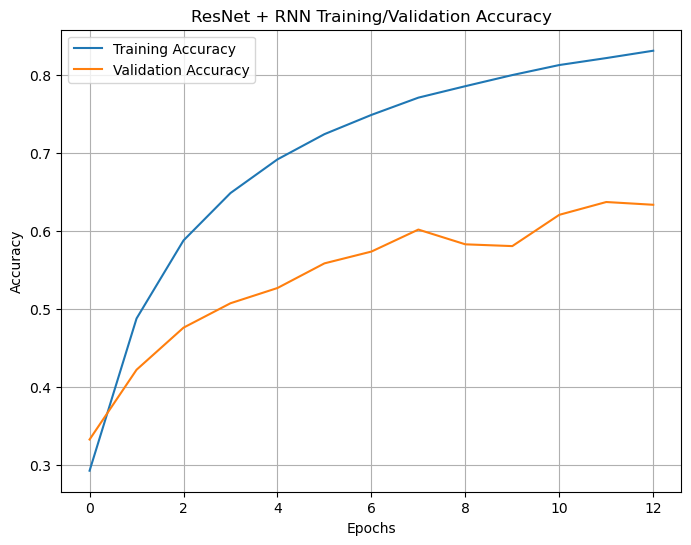

Epoch 1/30
4462/4462 ━━━━━━━━━━━━━━━━━━━━ 465s 104ms/step - accuracy: 0.1967 - loss: 2.7522 - val_accuracy: 0.2917 - val_loss: 2.6849
Epoch 2/30
4462/4462 ━━━━━━━━━━━━━━━━━━━━ 473s 106ms/step - accuracy: 0.4109 - loss: 1.9404 - val_accuracy: 0.3391 - val_loss: 2.5721
Epoch 3/30
4462/4462 ━━━━━━━━━━━━━━━━━━━━ 585s 131ms/step - accuracy: 0.4783 - loss: 1.6976 - val_accuracy: 0.3951 - val_loss: 2.4808
Epoch 4/30
4462/4462 ━━━━━━━━━━━━━━━━━━━━ 737s 165ms/step - accuracy: 0.5213 - loss: 1.5459 - val_accuracy: 0.4116 - val_loss: 2.4437
Epoch 5/30
4462/4462 ━━━━━━━━━━━━━━━━━━━━ 463s 104ms/step - accuracy: 0.5441 - loss: 1.4588 - val_accuracy: 0.4166 - val_loss: 2.4457
Epoch 6/30
4462/4462 ━━━━━━━━━━━━━━━━━━━━ 463s 104ms/step - accuracy: 0.5681 - loss: 1.3730 - val_accuracy: 0.4536 - val_loss: 2.3530
Epoch 7/30
4462/4462 ━━━━━━━━━━━━━━━━━━━━ 464s 104ms/step - accuracy: 0.5855 - loss: 1.3176 - val_accuracy: 0.4036 - val_loss: 2.5139
Epoch 8/30
4462/4462 ━━━━━━━━━━━━━━━━━━━━ 464s 104ms/step - ac

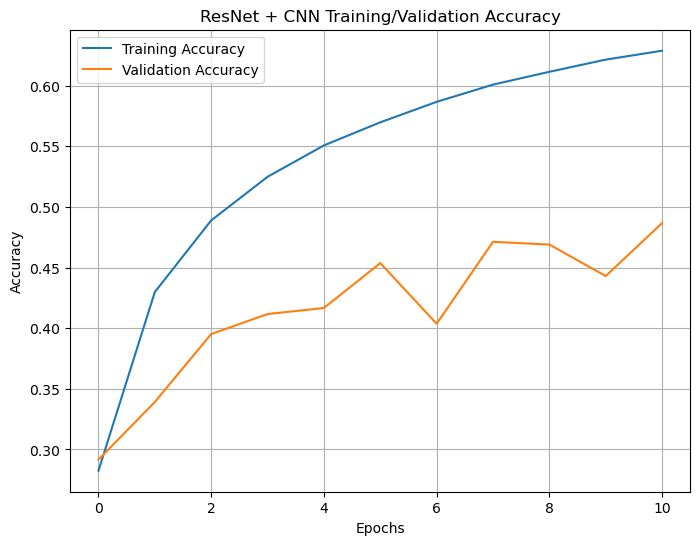

Epoch 1/30
4462/4462 ━━━━━━━━━━━━━━━━━━━━ 468s 104ms/step - accuracy: 0.2225 - loss: 2.6230 - val_accuracy: 0.3392 - val_loss: 2.3715
Epoch 2/30
4462/4462 ━━━━━━━━━━━━━━━━━━━━ 461s 103ms/step - accuracy: 0.4618 - loss: 1.7001 - val_accuracy: 0.4367 - val_loss: 2.1791
Epoch 3/30
4462/4462 ━━━━━━━━━━━━━━━━━━━━ 459s 103ms/step - accuracy: 0.5611 - loss: 1.3835 - val_accuracy: 0.4356 - val_loss: 2.1816
Epoch 4/30
4462/4462 ━━━━━━━━━━━━━━━━━━━━ 463s 104ms/step - accuracy: 0.6201 - loss: 1.2017 - val_accuracy: 0.5011 - val_loss: 1.9944
Epoch 5/30
4462/4462 ━━━━━━━━━━━━━━━━━━━━ 479s 107ms/step - accuracy: 0.6648 - loss: 1.0565 - val_accuracy: 0.5261 - val_loss: 2.0458
Epoch 6/30
4462/4462 ━━━━━━━━━━━━━━━━━━━━ 472s 106ms/step - accuracy: 0.6970 - loss: 0.9556 - val_accuracy: 0.5481 - val_loss: 1.9999
Epoch 7/30
4462/4462 ━━━━━━━━━━━━━━━━━━━━ 468s 105ms/step - accuracy: 0.7246 - loss: 0.8732 - val_accuracy: 0.5789 - val_loss: 1.9415
Epoch 8/30
4462/4462 ━━━━━━━━━━━━━━━━━━━━ 501s 112ms/step - ac

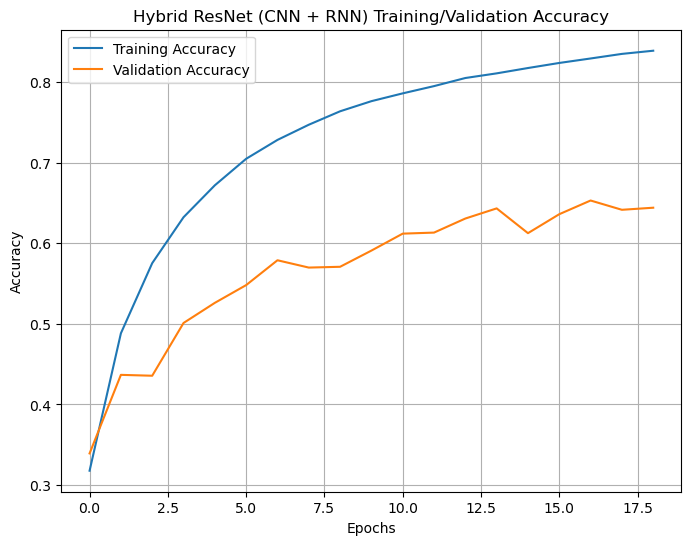

,Model,Validation Accuracy,Test Accuracy,Training Time (s)
0,ResNet + RNN,0.636975,0.748970,6224.311582
1,ResNet + CNN,0.486602,0.558347,5510.473770
2,Hybrid ResNet (CNN + RNN),0.653092,0.788241,9186.055146


In [43]:
results = []

# evaluate all models
history_resnet_rnn = evaluate_model(resnet_rnn_model, train_data, val_data, test_data, "ResNet + RNN")
history_resnet_cnn = evaluate_model(resnet_cnn_model, train_data, val_data, test_data, "ResNet + CNN")
history_hybrid = evaluate_model(hybrid_model, train_data, val_data, test_data, "Hybrid ResNet (CNN + RNN)")

# convert results to DataFrame
results_df = pd.DataFrame(results)

# display the results
results_df


In [ ]:
results_df